# Overlap Analysis

In this file we use the datasets generated in the scripts "Data_exploration" (krill pop, mean sequestration time) to performe the overlap analysis and identifie the Key Areas for Krill carbon Sequetsration (KAKS).

The script also generates the figures 1.C et 1.D of the manuscript which depicts the KAKS (plot and map).


In [1]:
# import libraries
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import math
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Cannot find header.dxf (GDAL_DATA is not defined)


In [2]:
# To be change with local directory of the data (file too heavy to be on git)
import os
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/outputs_formated_data/')

# Part 1 : indentify KAKS and other categories

## Load data

In [3]:
krill_pop = xr.open_dataset('Krill_biomass_final.nc')['krill_adult_log']
mean_time_seq = xr.open_dataset('xr_mean_time_seq_final.nc')
catch = xr.open_dataset('Krill_catch_array_final_all.nc')

mean_time_seq = mean_time_seq.rename_vars({'__xarray_dataarray_variable__' : 'mean_seq_time' })
catch = catch.rename_vars({'__xarray_dataarray_variable__' : 'krill_catch_density_log' })

In [4]:
# transform into dataframe
krill_pop = krill_pop.to_dataframe().reset_index().drop(['time'], axis =1) # 3600 rows × 3 columns
mean_time_seq = mean_time_seq.to_dataframe().reset_index().drop(['variable'], axis =1) # 3240 rows × 3 columns
catch = catch.to_dataframe().reset_index().drop(['variable'], axis =1) # 940 rows × 3 columns

### Create a dataset without NAN or "false zeros" that gather all three components

In [5]:
# remove the NaN and "false zeros" in the case of krill pop
krill_pop = krill_pop.dropna()[krill_pop['krill_adult_log'] != 0]
krill_pop.set_index(['latitude', 'longitude'], inplace = True) #1648  rows × 3 columns
krill_pop

C:\Users\anael\AppData\Local\Temp\ipykernel_10304\479033460.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  krill_pop = krill_pop.dropna()[krill_pop['krill_adult_log'] != 0]


krill_adult_log
latitude longitude                 
-75      -179               0.92934
         -177               1.70806
         -175               1.24843
         -173               1.46391
         -171               1.66276
...                             ...
-47       69                0.35615
          71                0.01810
-45       51                0.00947
          53                0.03058
          67                0.00009

[1648 rows x 1 columns]

In [6]:
mean_time_seq = mean_time_seq.dropna()
mean_time_seq = mean_time_seq.set_index(['latitude', 'longitude'])
mean_time_seq # 2384 

mean_seq_time
latitude longitude               
-75      -179          646.910548
         -177          601.882341
         -175          655.238074
         -173          641.075711
         -171          620.753036
...                           ...
-45       167           -0.000000
          173          162.285177
          175          131.782475
          177          207.926560
          179          117.346934

[2384 rows x 1 columns]

In [7]:
catch = catch.dropna()
catch.set_index(['latitude', 'longitude'], inplace = True)
catch # 227

krill_catch_density_log
latitude longitude                         
-69       5                        1.420883
          7                        0.001813
          9                        0.001086
          13                       2.759430
          29                       3.221415
...                                     ...
-53      -35                       6.628269
         -7                        1.298297
          35                       0.678965
          37                       4.051270
-51      -37                       2.817927

[227 rows x 1 columns]

In [8]:
# combine all points of the three variables with 'inner' join (we don't need the rows where we know time seq but not krill pop for ewample)
data = pd.merge(mean_time_seq, krill_pop, on = ['latitude', 'longitude'], how='inner')

# then we add the catch with an outer join because we want to keep data where there is no catch (it will create NaN
data = pd.merge(data, catch, on = ['latitude', 'longitude'], how='outer')
data # 1663

mean_seq_time  krill_adult_log  krill_catch_density_log
latitude longitude                                                         
-75      -179          646.910548          0.92934                      NaN
         -177          601.882341          1.70806                      NaN
         -175          655.238074          1.24843                      NaN
         -173          641.075711          1.46391                      NaN
         -171          620.753036          1.66276                      NaN
...                           ...              ...                      ...
-65       103                 NaN              NaN                 2.998282
          135                 NaN              NaN                 4.515547
-63      -57                  NaN              NaN                 6.403315
         -55                  NaN              NaN                 6.052593
-61      -55                  NaN              NaN                 6.377702

[1663 rows x 3 columns]

In [9]:
# Fill the remaing NAN in the catch column
data['krill_catch_density_log'] = data['krill_catch_density_log'].fillna(0)
data = data.dropna()

In [10]:
# sort the data by catch to have a nicer plot
data = data.sort_values(by=['krill_catch_density_log'])
data # 1647   rows

mean_seq_time  krill_adult_log  krill_catch_density_log
latitude longitude                                                         
-75      -179          646.910548          0.92934                 0.000000
-59       89           443.073307          0.79317                 0.000000
          87           418.119787          0.45726                 0.000000
          85           489.132537          0.94806                 0.000000
          83           330.379043          1.24424                 0.000000
...                           ...              ...                      ...
-61      -45           166.916928          1.46437                 6.736700
-53      -37           372.781837          1.85510                 6.764707
-63      -61            54.263430          1.74279                 7.014745
         -59             0.000000          1.74481                 7.140925
-61      -47           465.223682          2.14459                 7.384449

[1647 rows x 3 columns]

### Identify the KAKS
We calculate the quantile on datasets that have only the non-NaN rows, and no "falls zeros" in the case of krill pop, so it doesn't biais the quantile with many meaningless zeros. 
However, on the plot we use the datasets where all three components are gathered and rows where catch are "NaN" (beacuse no catch were reported there, are filled with 0 in order not the remove many points that will not appear on the plot otherwise.

In [11]:
krill_quantile = krill_pop.quantile(q=[0.3333, 0.6666]) # 1.049312 ; 1.522825
seq_quantile = mean_time_seq.quantile(q=[0.3333, 0.6666]) # 311.399158 ; 435.064221

In [12]:
krill_quantile

,krill_adult_log
0.3333,1.049312
0.6666,1.522825


In [13]:
seq_quantile 

,mean_seq_time
0.3333,311.399158
0.6666,435.064221


### We select the rows corresponding to points on each zone of interrest :
- upper right : both krill and time of sequestration are hight : it's the KAKS. label = 3; Orange
- lower right : abundant krill but low time of sequestration. label = 2; Green
- upper left : fewer krill but time of sequestration is hight. label = 1; Blue

Then map each group of cells with corresponding color code.

In [14]:
# upper right = the KAKS  : high krill and high carbon seq efficiency
UR_data = data.loc[(data['krill_adult_log'] > float(krill_quantile.iloc[1])) & (data['mean_seq_time'] > float(seq_quantile.iloc[1]))]
# add a column with label
UR_data['label'] = 3
UR_data # 383  rows × 3 columns

C:\Users\anael\AppData\Local\Temp\ipykernel_10304\3654684680.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  UR_data = data.loc[(data['krill_adult_log'] > float(krill_quantile.iloc[1])) & (data['mean_seq_time'] > float(seq_quantile.iloc[1]))]
C:\Users\anael\AppData\Local\Temp\ipykernel_10304\3654684680.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UR_data['label'] = 3


mean_seq_time  krill_adult_log  krill_catch_density_log  \
latitude longitude                                                            
-59      -17           568.430250          1.98212                 0.000000   
         -19           563.776827          1.99720                 0.000000   
         -21           558.410425          1.83919                 0.000000   
         -23           564.626310          1.88610                 0.000000   
         -27           550.332736          1.75705                 0.000000   
...                           ...              ...                      ...   
-61      -51           560.285164          2.15314                 4.606753   
-65       119         1019.370190          1.77930                 4.841430   
-59      -45           475.146058          2.26587                 5.988416   
         -47           507.101587          1.59669                 6.006303   
-61      -47           465.223682          2.14459                 7.384449   

                    label  
latitude longitude         
-59      -17            3  
         -19            3  
         -21            3  
         -23            3  
         -27            3  
...                   ...  
-61      -51            3  
-65       119           3  
-59      -45            3  
         -47            3  
-61      -47            3  

[383 rows x 4 columns]

In [15]:
# The lower right part = the areas with high krill population but low or medium carbon seq efficiency
LR_data = data.loc[(data['krill_adult_log'] > float(krill_quantile.iloc[1])) & (data['mean_seq_time'] < float(seq_quantile.iloc[1]))]
# add a column with label
LR_data['label'] = 2
LR_data # 167  rows × 3 columns

C:\Users\anael\AppData\Local\Temp\ipykernel_10304\3242380412.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  LR_data = data.loc[(data['krill_adult_log'] > float(krill_quantile.iloc[1])) & (data['mean_seq_time'] < float(seq_quantile.iloc[1]))]
C:\Users\anael\AppData\Local\Temp\ipykernel_10304\3242380412.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LR_data['label'] = 2


mean_seq_time  krill_adult_log  krill_catch_density_log  \
latitude longitude                                                            
-59      -55           381.910916          1.67820                 0.000000   
         -63           267.169752          1.69693                 0.000000   
-57      -39           415.812663          1.63503                 0.000000   
         -43           388.972264          1.64035                 0.000000   
         -45           372.190464          1.75436                 0.000000   
...                           ...              ...                      ...   
-55      -35             1.131965          2.55336                 6.598065   
-53      -35           397.678583          2.09880                 6.628269   
         -37           372.781837          1.85510                 6.764707   
-63      -61            54.263430          1.74279                 7.014745   
         -59             0.000000          1.74481                 7.140925   

                    label  
latitude longitude         
-59      -55            2  
         -63            2  
-57      -39            2  
         -43            2  
         -45            2  
...                   ...  
-55      -35            2  
-53      -35            2  
         -37            2  
-63      -61            2  
         -59            2  

[167 rows x 4 columns]

In [16]:
# the upper left categorie = The area of high carbon seq efficiency but low or medium krill density
UL_data = data.loc[(data['krill_adult_log'] < float(krill_quantile.iloc[1])) & (data['mean_seq_time'] > float(seq_quantile.iloc[1]))]
#UL_data = data.loc[(data['krill_adult_log'] < float(krill_quantile.iloc[0])) & (data['mean_seq_time'] > float(seq_quantile.iloc[1]))]
# add a column with label
UL_data['label'] = 1
UL_data # 410 rows × 3 columns

C:\Users\anael\AppData\Local\Temp\ipykernel_10304\3778080238.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  UL_data = data.loc[(data['krill_adult_log'] < float(krill_quantile.iloc[1])) & (data['mean_seq_time'] > float(seq_quantile.iloc[1]))]
C:\Users\anael\AppData\Local\Temp\ipykernel_10304\3778080238.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UL_data['label'] = 1


mean_seq_time  krill_adult_log  krill_catch_density_log  \
latitude longitude                                                            
-75      -179          646.910548          0.92934                 0.000000   
-59       89           443.073307          0.79317                 0.000000   
          85           489.132537          0.94806                 0.000000   
          91           454.005964          0.77758                 0.000000   
          59           460.545339          0.85478                 0.000000   
...                           ...              ...                      ...   
-61       45           620.716917          1.10589                 4.120356   
-63      -45           536.176878          1.43904                 4.279596   
-61       47           575.283708          1.18741                 4.393627   
-63       105          631.559937          1.16954                 4.567298   
-61      -57           633.909113          1.36171                 6.024380   

                    label  
latitude longitude         
-75      -179           1  
-59       89            1  
          85            1  
          91            1  
          59            1  
...                   ...  
-61       45            1  
-63      -45            1  
-61       47            1  
-63       105           1  
-61      -57            1  

[410 rows x 4 columns]

In [17]:
## Concatenate the three dataframe together
zones_data = pd.concat([UR_data, LR_data, UL_data])
zones_data #960  rows

mean_seq_time  krill_adult_log  krill_catch_density_log  \
latitude longitude                                                            
-59      -17           568.430250          1.98212                 0.000000   
         -19           563.776827          1.99720                 0.000000   
         -21           558.410425          1.83919                 0.000000   
         -23           564.626310          1.88610                 0.000000   
         -27           550.332736          1.75705                 0.000000   
...                           ...              ...                      ...   
-61       45           620.716917          1.10589                 4.120356   
-63      -45           536.176878          1.43904                 4.279596   
-61       47           575.283708          1.18741                 4.393627   
-63       105          631.559937          1.16954                 4.567298   
-61      -57           633.909113          1.36171                 6.024380   

                    label  
latitude longitude         
-59      -17            3  
         -19            3  
         -21            3  
         -23            3  
         -27            3  
...                   ...  
-61       45            1  
-63      -45            1  
-61       47            1  
-63       105           1  
-61      -57            1  

[960 rows x 4 columns]

In [18]:
## Join to the data dataframe to have the label of the areas, and then add a label = 0 for points that are not in the 3 categories
data_labeled = data.join(zones_data.drop(['mean_seq_time', 'krill_adult_log', 'krill_catch_density_log'], axis = 1)).fillna(0)
data_labeled # 1647 

mean_seq_time  krill_adult_log  krill_catch_density_log  \
latitude longitude                                                            
-75      -179          646.910548          0.92934                 0.000000   
-59       89           443.073307          0.79317                 0.000000   
          87           418.119787          0.45726                 0.000000   
          85           489.132537          0.94806                 0.000000   
          83           330.379043          1.24424                 0.000000   
...                           ...              ...                      ...   
-61      -45           166.916928          1.46437                 6.736700   
-53      -37           372.781837          1.85510                 6.764707   
-63      -61            54.263430          1.74279                 7.014745   
         -59             0.000000          1.74481                 7.140925   
-61      -47           465.223682          2.14459                 7.384449   

                    label  
latitude longitude         
-75      -179         1.0  
-59       89          1.0  
          87          0.0  
          85          1.0  
          83          0.0  
...                   ...  
-61      -45          0.0  
-53      -37          2.0  
-63      -61          2.0  
         -59          2.0  
-61      -47          3.0  

[1647 rows x 4 columns]

### Figure Bi-plot with the tier-tiles


lower left = 0
upper left = 1
lower right = 2
upper right = 3

C:\Users\anael\AppData\Local\Temp\ipykernel_10304\3606175437.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axvline(x=float(krill_quantile.iloc[0]), color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_10304\3606175437.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axvline(x=float(krill_quantile.iloc[1]), color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_10304\3606175437.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axhline(y=float(seq_quantile.iloc[0]), color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_10304\3606175437.py:13: FutureWarning: Calling float on a single element Series is deprecated a

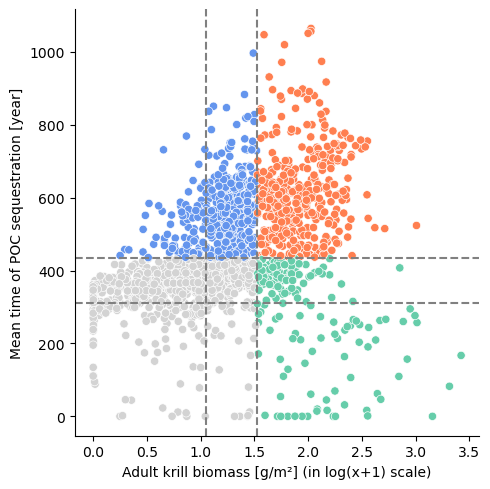

In [20]:
sns.relplot(x="krill_adult_log", y="mean_seq_time", 
            data=data_labeled,
            hue='label', 
            palette = ['lightgrey', 'cornflowerblue', 'mediumaquamarine', 'coral'],
            sizes = (10,70),
            legend=False)


plt.axvline(x=float(krill_quantile.iloc[0]), color='grey', linestyle='--')
plt.axvline(x=float(krill_quantile.iloc[1]), color='grey', linestyle='--')

plt.axhline(y=float(seq_quantile.iloc[0]), color='grey', linestyle='--')
plt.axhline(y=float(seq_quantile.iloc[1]), color='grey', linestyle='--')

plt.xlabel('Adult krill biomass [g/m²] (in log(x+1) scale)')
plt.ylabel('Mean time of POC sequestration [year]')

#plt.text(3.8, 400, '--- :  1/3 quantiles')

# saving in 'figure' folder
#os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/figures/')
#plt.savefig('bi_plot_categories.png')

plt.show()


## Map the KAKS and other categories
### Solve the problem of regularity of the spatial grid before ploting

When some coordinates are missing in the dataset, the sptial grid is not regular when we plot, thus we first solve this problem by matching a regular grid, with all the cells of the study zone to our 'zone_data' dataset.

In [21]:
# set index here with all coordinates
# make dataset with coordinates
coords = pd.DataFrame({'latitude':np.repeat(np.arange(-75, -45, 2), 180), # -75 to -51
                       'longitude': np.tile(np.arange(-179, 180, 2), 15), # -179 to 179
                       'label_grid': np.zeros(2700)}).set_index(['latitude', 'longitude'])

coords = coords.sort_values(['latitude', 'longitude'])
coords # 2700 rows

label_grid
latitude longitude            
-75      -179              0.0
         -177              0.0
         -175              0.0
         -173              0.0
         -171              0.0
...                        ...
-47       171              0.0
          173              0.0
          175              0.0
          177              0.0
          179              0.0

[2700 rows x 1 columns]

In [22]:
zones_data_complete = coords.join(data_labeled, how='left')
zones_data_complete#.dropna().shape # 2700  rows, 603 non-nan rows

label_grid  mean_seq_time  krill_adult_log  \
latitude longitude                                               
-75      -179              0.0     646.910548          0.92934   
         -177              0.0     601.882341          1.70806   
         -175              0.0     655.238074          1.24843   
         -173              0.0     641.075711          1.46391   
         -171              0.0     620.753036          1.66276   
...                        ...            ...              ...   
-47       171              0.0            NaN              NaN   
          173              0.0            NaN              NaN   
          175              0.0            NaN              NaN   
          177              0.0            NaN              NaN   
          179              0.0            NaN              NaN   

                    krill_catch_density_log  label  
latitude longitude                                  
-75      -179                           0.0    1.0  
         -177                           0.0    3.0  
         -175                           0.0    1.0  
         -173                           0.0    1.0  
         -171                           0.0    3.0  
...                                     ...    ...  
-47       171                           NaN    NaN  
          173                           NaN    NaN  
          175                           NaN    NaN  
          177                           NaN    NaN  
          179                           NaN    NaN  

[2700 rows x 5 columns]

In [23]:
zones_array = xr.Dataset.from_dataframe(zones_data_complete.drop(['krill_catch_density_log', 'krill_adult_log', 'mean_seq_time', 'label_grid'], axis = 1)) # convert into xarrayDataset
zones_array = xr.Dataset.to_array(zones_array)

In [24]:
zones_array

<xarray.DataArray (variable: 1, latitude: 15, longitude: 180)>
array([[[ 1.,  3.,  1., ...,  2.,  3.,  1.],
        [ 1.,  1.,  3., ...,  3.,  1.,  1.],
        [ 3.,  1.,  3., ...,  3.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * latitude   (latitude) int32 -75 -73 -71 -69 -67 -65 ... -55 -53 -51 -49 -47
  * longitude  (longitude) int32 -179 -177 -175 -173 -171 ... 173 175 177 179
  * variable   (variable) object 'label'

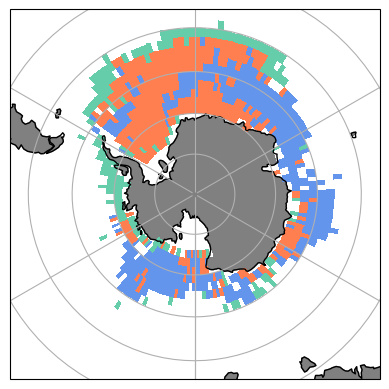

In [27]:
map_proj = ccrs.SouthPolarStereo()

p = zones_array.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj}, # the plot's projection
    levels=[1, 2, 3, 4], 
    colors = ['white', 'cornflowerblue', 'mediumaquamarine', 'coral']
)  


### Add features:
p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
plt.title('')

# save
#os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/figures/')
#plt.savefig('p_overlap_krill_carbon.png')

plt.show(p)

# Save
Save dataframe and netcdf of the categorie in the outputs results folder.

In [42]:
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/output_results/')
# Save the dataframe 
zones_data_complete.to_csv('zones_krill_carbon.csv')
# save the xarray
zones_array.to_netcdf('zones_krill_carbon.nc')

# Part 2 : Protection and exploitation in the KAKS and other categories

Now we add the data on protection (current and project MPAs) and the catch data to show
- the distribution of harvest in each category
- Identify areas of potential conflict between krill fihsing and krill carbon sequestration (here fater named COCAs)
- the level if protection of each category

## Part 2.1 : Harvesting distribution
Show catch distribution on each categories

C:\Users\anael\AppData\Local\Temp\ipykernel_13796\273884724.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axvline(x=float(krill_quantile.iloc[0]), alpha = 0.5, color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_13796\273884724.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axvline(x=float(krill_quantile.iloc[1]), alpha = 0.5, color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_13796\273884724.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axhline(y=float(seq_quantile.iloc[0]), alpha = 0.5, color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_13796\273884724.py:14: FutureWarning: Calling float on a s

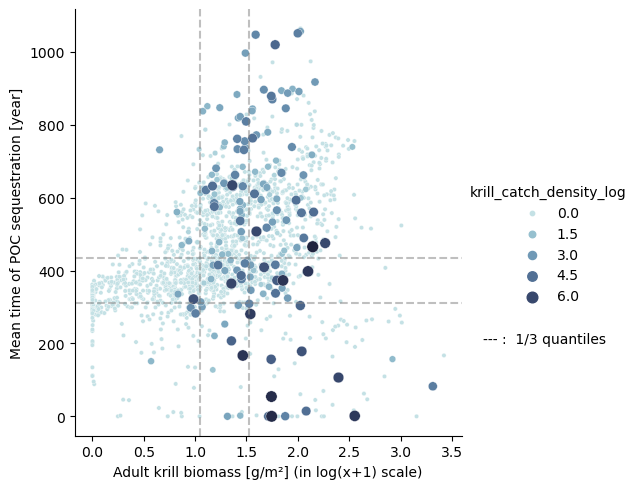

In [26]:
sns.relplot(x="krill_adult_log", y="mean_seq_time", 
            data=data,
            hue='krill_catch_density_log', 
            size = 'krill_catch_density_log',
            #style="Protection_status",
            palette = sns.cubehelix_palette(rot=-.2, as_cmap=True),
           sizes = (10,70))


plt.axvline(x=float(krill_quantile.iloc[0]), alpha = 0.5, color='grey', linestyle='--')
plt.axvline(x=float(krill_quantile.iloc[1]), alpha = 0.5, color='grey', linestyle='--')

plt.axhline(y=float(seq_quantile.iloc[0]), alpha = 0.5, color='grey', linestyle='--')
plt.axhline(y=float(seq_quantile.iloc[1]), alpha = 0.5, color='grey', linestyle='--')

plt.xlabel('Adult krill biomass [g/m²] (in log(x+1) scale)')
plt.ylabel('Mean time of POC sequestration [year]')

plt.text(3.8, 200, '--- :  1/3 quantiles')

plt.show()

### Recomendations for fished areas : identify COCAs
We separate the fished from the unfished sites in order to give different recommendations in terms of protection and in terms of management of the already existing fishery.

Regarding the fished areas, we identify potentially conflicting areas between the tow "services" mediated by krill : carbon sequestration and harvesting.

COCA-F = Conflicting Areas between Ocean carbon and Fishing. (General concept also used in other study on fishery of other species)
COCA-F are defined as the areas where the most krill biomass is fished (in absolute value of catch, not as a proportion of the krill local biomass because the biomass catched is related to potential impact of fihsing on the krill carbon sink, the potential sequestration deficit mediated by fishing), and the areas where the carbon sequestration efficiency is high (upper part of the biplot).

High fishing areas are defined as the upper 0.5-quantile of the catch density: the primary fishing grounds (above a threshold of 2.4 in log scale).

In [33]:
# cut the dataset to separate the fishing = 0 and the rest
data_fished_sites = zones_data[zones_data['krill_catch_density_log'] != 0] # (210, 3)

In [34]:
data_fished_sites

mean_seq_time  krill_adult_log  krill_catch_density_log  \
latitude longitude                                                            
-69       75           931.067384          1.63685                 0.000021   
          9            870.173284          1.99226                 0.001086   
-65       37           659.319705          1.63480                 0.001166   
          39           700.573143          1.53151                 0.001166   
-69       7            828.773428          2.11914                 0.001813   
...                           ...              ...                      ...   
-61       45           620.716917          1.10589                 4.120356   
-63      -45           536.176878          1.43904                 4.279596   
-61       47           575.283708          1.18741                 4.393627   
-63       105          631.559937          1.16954                 4.567298   
-61      -57           633.909113          1.36171                 6.024380   

                    label  
latitude longitude         
-69       75            3  
          9             3  
-65       37            3  
          39            3  
-69       7             3  
...                   ...  
-61       45            1  
-63      -45            1  
-61       47            1  
-63       105           1  
-61      -57            1  

[177 rows x 4 columns]

In [37]:
## Select COCAs
COCA = data_fished_sites[(data_fished_sites['krill_catch_density_log'] > 2.4) & ((data_fished_sites['label'] == 3) | (data_fished_sites['label'] == 1))]
COCA.shape # 56 rows

(56, 4)

### Plot the COCA-F

Generates the Figure 5.B

C:\Users\anael\AppData\Local\Temp\ipykernel_10304\2937652839.py:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axvline(x=float(krill_quantile.iloc[0]), alpha = 0.5, color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_10304\2937652839.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axvline(x=float(krill_quantile.iloc[1]), alpha = 0.5, color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_10304\2937652839.py:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axhline(y=float(seq_quantile.iloc[0]), alpha = 0.5, color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_10304\2937652839.py:52: FutureWarning: Calling float on

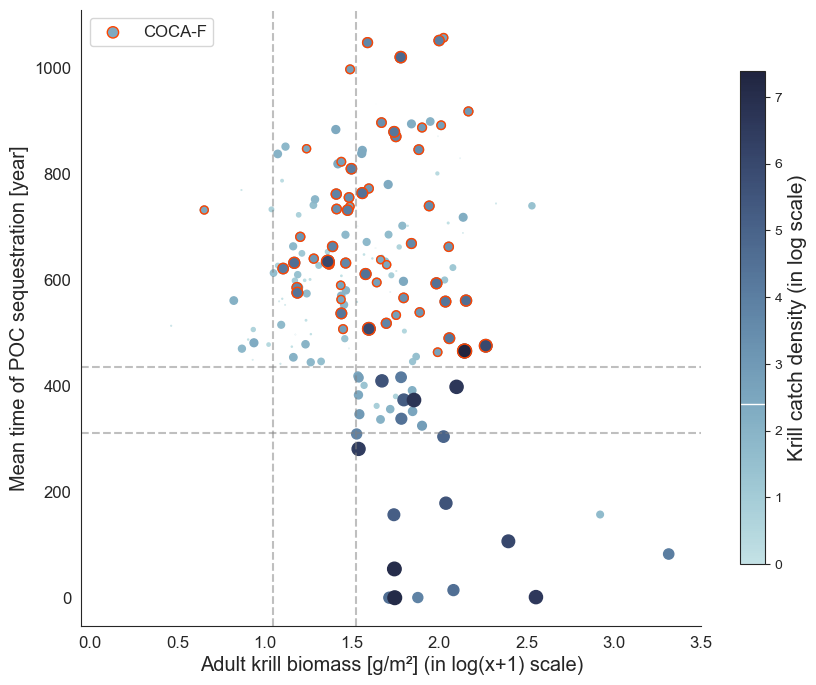

In [39]:
# limits to have the same scale on all plots
c_min = 0
c_max = max(data_fished_sites['krill_catch_density_log'])# 7.38

s_min = 0
s_max = max(data_fished_sites['krill_catch_density_log'])# 7.38

# create figure
fig = plt.figure()
ax1 = fig.add_subplot(111)

sns.set_style("white")
sns.despine()

p= ax1.scatter(data_fished_sites["krill_adult_log"], data_fished_sites["mean_seq_time"],
            s= (data_fished_sites['krill_catch_density_log'] - s_min) / (s_max - s_min) * 100, 
            c=data_fished_sites['krill_catch_density_log'],
            cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True),
            vmin=c_min, vmax=c_max)

p2=ax1.scatter(COCA["krill_adult_log"], COCA["mean_seq_time"], 
            s= (COCA['krill_catch_density_log'] - s_min) / (s_max - s_min) * 100, 
            c=COCA['krill_catch_density_log'], 
            cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True),
            vmin=c_min, vmax=c_max,
            marker="o", 
            linewidths = 1,
            edgecolor = 'orangered',
            label = 'COCA-F')


cb = plt.colorbar(p, label = 'Krill catch density', shrink = 0.8, location='right')#, boundaries = np.linspace(0,7.5,36))
cb.set_label(label='Krill catch density (in log scale)', size=15)
cax = cb.ax
cax.axhline(2.4, c='white', linewidth = 1)


for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(12)

fig.set_figwidth(10)
fig.set_figheight(8)


plt.legend(loc='upper left', fontsize = 'large')

plt.axvline(x=float(krill_quantile.iloc[0]), alpha = 0.5, color='grey', linestyle='--')
plt.axvline(x=float(krill_quantile.iloc[1]), alpha = 0.5, color='grey', linestyle='--')

plt.axhline(y=float(seq_quantile.iloc[0]), alpha = 0.5, color='grey', linestyle='--')
plt.axhline(y=float(seq_quantile.iloc[1]), alpha = 0.5, color='grey', linestyle='--')

plt.xlabel('Adult krill biomass [g/m²] (in log(x+1) scale)', fontsize = 'x-large')
plt.ylabel('Mean time of POC sequestration [year]', fontsize = 'x-large')

ax1.set_xlim([-0.05, 3.5])

# saving in 'figure' folder
#os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/figures/')
#fig.savefig('biplot_discussion_fished_sites.png', dpi=300)

## Part 2.2 : Protection level

Take unfished cells and swhow where are proetcetd cells in the category plot.
### Add the protection status to visualize the cells within MPA

In [43]:
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/output_results/')

MPA_status = pd.read_csv('mpas_extracted.csv').set_index(['latitude', 'longitude']).drop(['label'], axis =1) # the files include Weddell (project MPA)
MPA_status

Protection_status
latitude longitude                   
-61.0     165.0        Ross_protected
          167.0        Ross_protected
-65.0     161.0        Ross_protected
          163.0        Ross_protected
          165.0        Ross_protected
...                               ...
-75.0    -35.0      Weddell_protected
         -33.0      Weddell_protected
         -31.0      Weddell_protected
         -29.0      Weddell_protected
         -27.0      Weddell_protected

[147 rows x 1 columns]

In [44]:
# merge with 'data' to add the protection status
data_protec = data_labeled.join(MPA_status, how='left')
data_protec.fillna('non_protected', inplace = True)
data_protec

mean_seq_time  krill_adult_log  krill_catch_density_log  \
latitude longitude                                                            
-75      -179          646.910548          0.92934                 0.000000   
-59       89           443.073307          0.79317                 0.000000   
          87           418.119787          0.45726                 0.000000   
          85           489.132537          0.94806                 0.000000   
          83           330.379043          1.24424                 0.000000   
...                           ...              ...                      ...   
-61      -45           166.916928          1.46437                 6.736700   
-53      -37           372.781837          1.85510                 6.764707   
-63      -61            54.263430          1.74279                 7.014745   
         -59             0.000000          1.74481                 7.140925   
-61      -47           465.223682          2.14459                 7.384449   

                    label Protection_status  
latitude longitude                           
-75      -179         1.0    Ross_protected  
-59       89          1.0     non_protected  
          87          0.0     non_protected  
          85          1.0     non_protected  
          83          0.0     non_protected  
...                   ...               ...  
-61      -45          0.0     non_protected  
-53      -37          2.0     non_protected  
-63      -61          2.0     non_protected  
         -59          2.0     non_protected  
-61      -47          3.0     non_protected  

[1647 rows x 5 columns]

In [45]:
# here make the opposite joining to plot only protected sites 
protected_sites = MPA_status.join(data_labeled, how='left')#.dropna()
protected_sites

Protection_status  mean_seq_time  krill_adult_log  \
latitude longitude                                                      
-61.0     165.0        Ross_protected     377.357221          1.54598   
          167.0        Ross_protected     369.856781          1.37479   
-65.0     161.0        Ross_protected     564.941226          1.43204   
          163.0        Ross_protected     574.928127          1.44244   
          165.0        Ross_protected     548.001368          1.65140   
...                               ...            ...              ...   
-75.0    -35.0      Weddell_protected     762.396612          2.39324   
         -33.0      Weddell_protected     776.926134          2.34088   
         -31.0      Weddell_protected     740.448852          2.17867   
         -29.0      Weddell_protected     605.997449          2.35001   
         -27.0      Weddell_protected     145.588792          1.96967   

                    krill_catch_density_log  label  
latitude longitude                                  
-61.0     165.0                         0.0    2.0  
          167.0                         0.0    0.0  
-65.0     161.0                         0.0    1.0  
          163.0                         0.0    1.0  
          165.0                         0.0    3.0  
...                                     ...    ...  
-75.0    -35.0                          0.0    3.0  
         -33.0                          0.0    3.0  
         -31.0                          0.0    3.0  
         -29.0                          0.0    3.0  
         -27.0                          0.0    2.0  

[147 rows x 5 columns]

## Recommendations for the unfished areas

this generates the Figure 5.A of the manuscript.

In [48]:
# cut the dataset to separate the fishing = 0 and the rest
data_unfished_sites = data[data['krill_catch_density_log'] == 0] # (1437, 3)

In [49]:
# Separate the "truly protected sites", from the Weddell mpa which is in project
protected_sites_SO_Ross = protected_sites[protected_sites['Protection_status'] != 'Weddell_protected']
protected_sites_Weddell = protected_sites[protected_sites['Protection_status'] == 'Weddell_protected']

C:\Users\anael\AppData\Local\Temp\ipykernel_10304\2564054003.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axvline(x=float(krill_quantile.iloc[0]), alpha = 0.5, color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_10304\2564054003.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axvline(x=float(krill_quantile.iloc[1]), alpha = 0.5, color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_10304\2564054003.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axhline(y=float(seq_quantile.iloc[0]), alpha = 0.5, color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_10304\2564054003.py:42: FutureWarning: Calling float on

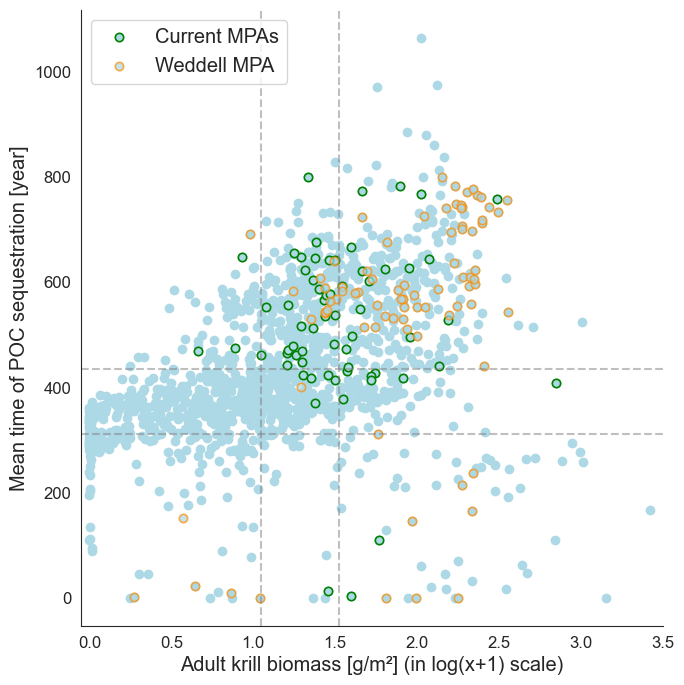

In [52]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

sns.set_style("white")
sns.despine()

p= ax1.scatter(data_unfished_sites["krill_adult_log"], data_unfished_sites["mean_seq_time"],
              color = 'lightblue')


p3=ax1.scatter(protected_sites_SO_Ross["krill_adult_log"], protected_sites_SO_Ross["mean_seq_time"],
            marker="o", 
            color = 'lightblue',
            linewidths = 1.2,
            edgecolor = 'g',
            label = 'Current MPAs')



p2=ax1.scatter(protected_sites_Weddell["krill_adult_log"], protected_sites_Weddell["mean_seq_time"],
            marker="o", 
            color = 'lightblue',
            linewidths = 1.2,
            edgecolor = 'darkorange',
            alpha= 0.7,
            label = 'Weddell MPA')


for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(12)

fig.set_figwidth(7.5)
fig.set_figheight(8)

plt.legend(loc='upper left', fontsize = 'x-large')

plt.axvline(x=float(krill_quantile.iloc[0]), alpha = 0.5, color='grey', linestyle='--')
plt.axvline(x=float(krill_quantile.iloc[1]), alpha = 0.5, color='grey', linestyle='--')

plt.axhline(y=float(seq_quantile.iloc[0]), alpha = 0.5, color='grey', linestyle='--')
plt.axhline(y=float(seq_quantile.iloc[1]), alpha = 0.5, color='grey', linestyle='--')

plt.xlabel('Adult krill biomass [g/m²] (in log(x+1) scale)', fontsize = 'x-large')
plt.ylabel('Mean time of POC sequestration [year]', fontsize = 'x-large')

ax1.set_xlim([-0.05, 3.5])

# saving in 'figure' folder
#os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/figures/')
#fig.savefig('biplot_discussion_unfished.png', dpi=300)

C:\Users\anael\AppData\Local\Temp\ipykernel_10304\1810025381.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axvline(x=float(krill_quantile.iloc[0]), alpha = 0.5, color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_10304\1810025381.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axvline(x=float(krill_quantile.iloc[1]), alpha = 0.5, color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_10304\1810025381.py:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axhline(y=float(seq_quantile.iloc[0]), alpha = 0.5, color='grey', linestyle='--')
C:\Users\anael\AppData\Local\Temp\ipykernel_10304\1810025381.py:49: FutureWarning: Calling float on

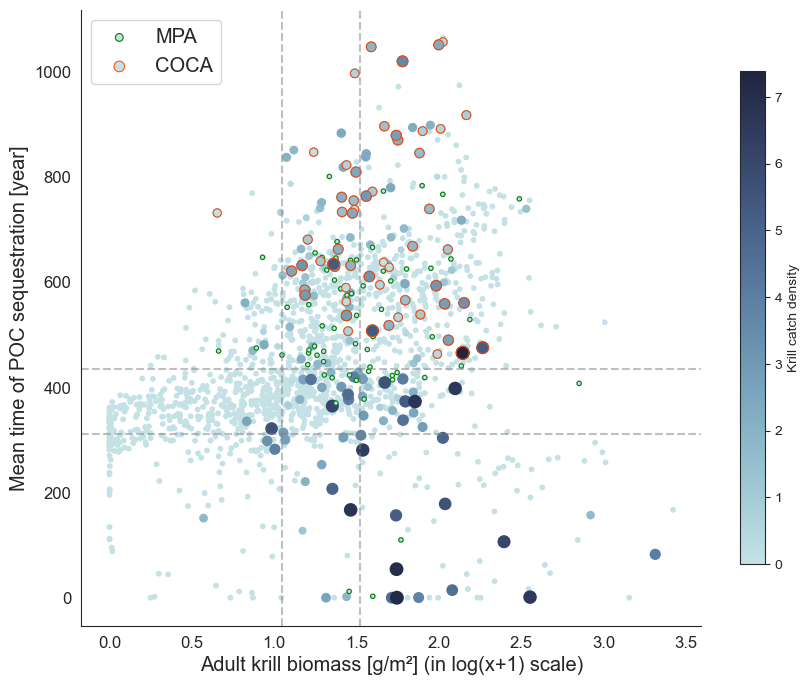

In [53]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

sns.set_style("white")
sns.despine()

p= ax1.scatter(data["krill_adult_log"], data["mean_seq_time"], 
            s=(data['krill_catch_density_log']+1)*10, 
            c=data['krill_catch_density_log'],
           cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True))
           #label = 'not protected')

#plt.legend(*p.legend_elements("colors"))
#p.legend_elements(prop="colors", alpha=0.6)

p2=ax1.scatter(protected_sites_SO_Ross["krill_adult_log"], protected_sites_SO_Ross["mean_seq_time"], 
            s= (protected_sites_SO_Ross['krill_catch_density_log']+1)*10, 
            c=protected_sites_SO_Ross['krill_catch_density_log'], 
            cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True),
            marker="o", 
            linewidths = 0.8,
            edgecolor = 'green',
            label = 'MPA')

p3=ax1.scatter(COCA["krill_adult_log"], COCA["mean_seq_time"], 
            s= (COCA['krill_catch_density_log']+1)*10, 
            c=COCA['krill_catch_density_log'], 
            cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True),
            marker="o", 
            linewidths = 0.7,
            edgecolor = 'orangered',
            label = 'COCA')

cb = plt.colorbar(p, label = 'Krill catch density', shrink = 0.8)

for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(12)
    
fig.set_figwidth(10)
fig.set_figheight(8)

plt.legend(loc='upper left', fontsize = 'x-large')

plt.axvline(x=float(krill_quantile.iloc[0]), alpha = 0.5, color='grey', linestyle='--')
plt.axvline(x=float(krill_quantile.iloc[1]), alpha = 0.5, color='grey', linestyle='--')

plt.axhline(y=float(seq_quantile.iloc[0]), alpha = 0.5, color='grey', linestyle='--')
plt.axhline(y=float(seq_quantile.iloc[1]), alpha = 0.5, color='grey', linestyle='--')

plt.xlabel('Adult krill biomass [g/m²] (in log(x+1) scale)', fontsize = 'x-large')
plt.ylabel('Mean time of POC sequestration [year]', fontsize = 'x-large')

#plt.text(3.8, 100, '--- :  1/3 quantiles', fontsize = 'large')

# saving in 'figure' folder
#os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/figures/')
#fig.savefig('biplot_discussion_with_COCA_MPA.png', dpi=300)

plt.show()